<a href="https://colab.research.google.com/github/lasiadhi/Prediction-of-hypoxemia-trend/blob/master/outcome_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#################################################
###### @author: Lasith Adhikari (python 3)  #####
############ Created on Nov 25, 2019 ############
# Code description: 
# Generate PF value (hypoxemia level) near IV start and before IV start + 24h

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
from google.colab import files
import seaborn as sns
import pickle
import matplotlib.pyplot as plt 
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [0]:
auth.authenticate_user()

In [0]:
# Note that this should be the project for the datathon work,
# not the physionet-data project which is for data hosting.
project_id = 'hst-953-2019'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [7]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read ICU IV start times:
first_icuid_dict = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/IV_LOS24_adult_firstICU_dict.pkl", "rb" ) )

In [9]:
len(first_icuid_dict.keys())

38823

In [9]:
# Were there any first ICU eps had start time missing? 0
cn = 0
for i in first_icuid_dict.keys():
  first_ep = first_icuid_dict[i]['IV'][0]
  if np.isnan(first_ep[0]):
    cn += 1
print(cn)

0


In [10]:
# Were there any first ICU eps had end time missing? 8143
cn = 0
for i in first_icuid_dict.keys():
  first_ep = first_icuid_dict[i]['IV'][0]
  if np.isnan(first_ep[1]):
    cn += 1
print(cn)

8143


In [0]:
# read PF values
#both_p_f = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/both_p_f", "rb" ) )
#impute_p_f = pickle.load(open("/content/drive/My Drive/Colab Notebooks/data/impute_p_f", "rb" ) )

In [19]:
#both_p_f.patientunitstayid.nunique()

6807

## Compute PF-ratio

In [0]:
df_outcome = run_query("""
select patientunitstayid, chartoffset, fio2, pao2
from `physionet-data.eicu_crd_derived.pivoted_bg` 
order by patientunitstayid, chartoffset
"""
)

In [11]:
df_outcome.head()

,patientunitstayid,chartoffset,fio2,pao2
0,141168,516,NaN,NaN
1,141168,1133,NaN,NaN
2,141168,1805,0.28,41.0
3,141168,2010,1.00,42.0
4,141168,2026,NaN,68.0


In [0]:
df_outcome_NL = df_outcome[df_outcome.pao2.notnull()].reset_index(drop=True)

In [13]:
df_outcome_NL


,patientunitstayid,chartoffset,fio2,pao2
0,141168,1805,0.28,41.0
1,141168,2010,1.00,42.0
2,141168,2026,NaN,68.0
3,141168,2141,NaN,121.0
4,141194,2102,0.28,100.0
...,...,...,...,...
414345,3353251,4510,0.40,72.0
414346,3353251,5598,0.40,68.0
414347,3353251,9901,0.45,80.0
414348,3353251,11054,0.40,87.0


In [0]:
# fill forward fio2 values within each pts id.
df_outcome_NL.fio2 = df_outcome_NL.groupby('patientunitstayid')['fio2'].ffill()

In [15]:
df_outcome_NL

,patientunitstayid,chartoffset,fio2,pao2
0,141168,1805,0.28,41.0
1,141168,2010,1.00,42.0
2,141168,2026,1.00,68.0
3,141168,2141,1.00,121.0
4,141194,2102,0.28,100.0
...,...,...,...,...
414345,3353251,4510,0.40,72.0
414346,3353251,5598,0.40,68.0
414347,3353251,9901,0.45,80.0
414348,3353251,11054,0.40,87.0


In [0]:
# now drop any rows with fio2 still null
df_outcome_NL = df_outcome_NL[df_outcome_NL.fio2.notnull()]

In [17]:
df_outcome_NL

,patientunitstayid,chartoffset,fio2,pao2
0,141168,1805,0.28,41.0
1,141168,2010,1.00,42.0
2,141168,2026,1.00,68.0
3,141168,2141,1.00,121.0
4,141194,2102,0.28,100.0
...,...,...,...,...
414344,3353251,3864,0.40,73.0
414345,3353251,4510,0.40,72.0
414346,3353251,5598,0.40,68.0
414347,3353251,9901,0.45,80.0


In [18]:
df_outcome_NL.pao2.describe()

count    327629.000000
mean        120.640156
std          82.043248
min          15.000000
25%          73.000000
50%          93.000000
75%         134.000000
max         702.000000
Name: pao2, dtype: float64

In [19]:
# compute the PF-ratio:
df_outcome_NL['pf_ratio'] = round(df_outcome_NL['pao2']/df_outcome_NL['fio2'],2)
df_outcome_NL.loc[df_outcome_NL['pf_ratio']>1000,'pf_ratio']=1000.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
df_outcome_NL['pf_ratio'].describe()

count    327629.000000
mean        239.056291
std         141.917658
min          15.000000
25%         141.670000
50%         212.750000
75%         307.000000
max        1000.000000
Name: pf_ratio, dtype: float64

In [21]:
df_outcome_NL

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
0,141168,1805,0.28,41.0,146.43
1,141168,2010,1.00,42.0,42.00
2,141168,2026,1.00,68.0,68.00
3,141168,2141,1.00,121.0,121.00
4,141194,2102,0.28,100.0,357.14
...,...,...,...,...,...
414344,3353251,3864,0.40,73.0,182.50
414345,3353251,4510,0.40,72.0,180.00
414346,3353251,5598,0.40,68.0,170.00
414347,3353251,9901,0.45,80.0,177.78


In [22]:
(df_outcome_NL.chartoffset/60.0).describe()

count    327629.000000
mean         76.057297
std        1405.238547
min     -788659.500000
25%           3.100000
50%          26.933333
75%         101.750000
max        6802.616667
Name: chartoffset, dtype: float64

In [23]:
# no of icu stays in pf ratio dataset:
df_outcome_NL.patientunitstayid.nunique()

65643

In [0]:
# Pick the PF value close to 24hr time point from the first IV start time

In [0]:
first24hr_pf = pd.DataFrame()
for icu_id in first_icuid_dict.keys():
  MV_list = first_icuid_dict[icu_id]['IV']
  first_MV_start = MV_list[0][0]
  MV_plus_24hr =   first_MV_start + 24.0 # watch period end time from the first MV

  for MV_i in MV_list[::-1]:  
      #if (~np.isnan(first_MV_start)): # check if the start of fist MV is nan
      found_pf = 0 # set to 1 once we found a valid pf value

        # read all PF-ratio values first
      pf_both_df = df_outcome_NL[df_outcome_NL.patientunitstayid==icu_id].sort_values(by='chartoffset', ascending=False).reset_index(drop=True)
      pf_both_df['chartoffset'] = pf_both_df['chartoffset']/60.0

      for i,row in pf_both_df.iterrows():
        if ((row['chartoffset']) <= min(MV_plus_24hr, MV_i[1])) & ((row['chartoffset']) >= MV_i[0]):
          temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['chartoffset']], 'pf_ratio': [row['pf_ratio']]})
          first24hr_pf = pd.concat([first24hr_pf, temp])
          found_pf = 1
          break 

        # if pf_both not found, get pf from imputed table if availabel
        #if found_pf==0:
         # pf_impute_df = impute_p_f[impute_p_f.patientunitstayid==icu_id].sort_values(by='time_diff', ascending=False).reset_index(drop=True)
         # pf_impute_df['time_diff'] = pf_impute_df['time_diff']/60.0
         # for i,row in pf_impute_df.iterrows():
         #   if ((row['time_diff']) <= min(MV_plus_24hr, MV_i[1])) & (row['time_diff'] >= MV_i[0]):
         #     temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['time_diff']], 'pf_ratio': [row['pf_ratio']]})
          #    first24hr_pf = pd.concat([first24hr_pf, temp])
          #    break 

      if found_pf==1: 
         break  

In [0]:
def hypo_outcome(x):
  if x<=100.0:
    return 'severe'
  elif (x>100) & (x<=200):
    return 'moderate'
  elif (x>200) & (x<=300):
    return 'mild'
  else:
    return 'no hypoxemia'

In [0]:
first24hr_pf['hyp_cat'] = first24hr_pf.pf_ratio.apply(hypo_outcome)

In [88]:
first24hr_pf.head()

,patientunitstayid,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last
0,141451,15.000000,251.43,mild
0,141515,19.083333,217.50,mild
0,141806,21.966667,230.00,mild
0,141844,14.333333,245.00,mild
0,141853,2.516667,167.50,moderate


In [30]:
first24hr_pf.patientunitstayid.nunique()

27277

In [27]:
first24hr_pf.chartoffset_hrs.describe()

count    27277.000000
mean        19.367140
std         29.520799
min       -254.883333
25%          6.200000
50%         13.900000
75%         21.633333
max       1615.800000
Name: chartoffset_hrs, dtype: float64

In [0]:
# sanity check  

In [37]:
first24hr_pf[first24hr_pf.chartoffset_hrs<0]

,patientunitstayid,chartoffset_hrs,pf_ratio
0,189727,-0.966667,265.00
0,275632,-4.866667,61.00
0,295870,-11.283333,41.00
0,335773,-1.916667,133.00
0,999150,-66.533333,372.00
...,...,...,...
0,3347798,-0.766667,63.00
0,3349850,-1.216667,295.00
0,3352123,-2.550000,248.00
0,3352512,-1.400000,174.00


In [38]:
first_icuid_dict[999150]

{'ICU Admit': [0], 'ICU Discharge': [85.17], 'IV': [(-86.2, 54.3)]}

In [40]:
first24hr_pf[first24hr_pf.chartoffset_hrs>1000]

,patientunitstayid,chartoffset_hrs,pf_ratio
0,157644,1615.8,351.43


In [41]:
first_icuid_dict[157644]

{'ICU Admit': [0],
 'ICU Discharge': [1987.93],
 'IV': [(1601.52, 1606.9), (1609.37, 1719.35)]}

In [42]:
df_outcome_NL[df_outcome_NL.patientunitstayid==157644]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
4952,157644,3888,0.28,84.0,300.00
4953,157644,94737,0.28,183.0,653.57
4954,157644,94839,0.28,193.0,689.29
4955,157644,94869,0.28,431.0,1000.00
4956,157644,94905,0.28,240.0,857.14
4957,157644,94940,0.28,276.0,985.71
4958,157644,94971,0.28,299.0,1000.00
4959,157644,95022,0.28,294.0,1000.00
4960,157644,95076,0.28,133.0,475.00
4961,157644,95160,0.40,130.0,325.00


In [0]:
# Pick the PF value close to IV start time:

In [0]:
first_pf = pd.DataFrame()
for icu_id in first_icuid_dict.keys():
  MV_list = first_icuid_dict[icu_id]['IV']
  first_MV_start = MV_list[0][0]
  MV_plus_24hr =   first_MV_start + 24.0 # watch period end time from the first MV

  for MV_i in MV_list: # start from the begining 
      found_pf = 0 # set to 1 once we found a valid pf value

        # read all PF-ratio values first
      pf_both_df = df_outcome_NL[df_outcome_NL.patientunitstayid==icu_id].sort_values(by='chartoffset', ascending=True).reset_index(drop=True)
      pf_both_df['chartoffset'] = pf_both_df['chartoffset']/60.0

      for i,row in pf_both_df.iterrows():
        if ((row['chartoffset']) <= min(MV_plus_24hr, MV_i[1])) & ((row['chartoffset']) >= MV_i[0]):
          temp = pd.DataFrame({'patientunitstayid': [icu_id],'chartoffset_hrs':[row['chartoffset']], 'pf_ratio': [row['pf_ratio']]})
          first_pf = pd.concat([first_pf, temp])
          found_pf = 1
          break 

      if found_pf==1: 
         break  

In [0]:
first_pf['hyp_cat'] = first_pf.pf_ratio.apply(hypo_outcome)

In [46]:
first_pf.head()

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141451,1.250000,161.00,moderate
0,141515,1.500000,283.00,mild
0,141806,1.416667,176.67,moderate
0,141844,0.983333,260.00,mild
0,141853,1.083333,198.33,moderate


In [58]:
first_pf.patientunitstayid.nunique()

27277

In [0]:
# Sanity check:

In [48]:
# example 1:
df_outcome_NL[df_outcome_NL.patientunitstayid==141451]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
90,141451,45,0.35,80.0,228.57
91,141451,75,1.00,161.0,161.00
92,141451,145,0.70,142.0,202.86
93,141451,760,0.35,94.0,268.57
94,141451,900,0.35,88.0,251.43
95,141451,1150,0.40,135.0,337.50


In [49]:
first_icuid_dict[141451]

{'ICU Admit': [0], 'ICU Discharge': [64.72], 'IV': [(0.87, 16.45)]}

In [50]:
first_pf[first_pf.patientunitstayid==141451]


,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141451,1.25,161.0,moderate


In [51]:
first24hr_pf[first24hr_pf.patientunitstayid==141451]


,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141451,15.0,251.43,mild


In [54]:
# example 2:
df_outcome_NL[df_outcome_NL.patientunitstayid==141515]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
100,141515,90,1.0,283.0,283.00
101,141515,200,0.5,55.0,110.00
102,141515,270,0.7,71.0,101.43
103,141515,425,0.7,85.0,121.43
104,141515,575,0.7,133.0,190.00
105,141515,1145,0.4,87.0,217.50
106,141515,1990,0.4,78.0,195.00
107,141515,2610,0.4,126.0,315.00
108,141515,4075,0.4,104.0,260.00
109,141515,5520,0.4,100.0,250.00


In [55]:
first_icuid_dict[141515]

{'ICU Admit': [0], 'ICU Discharge': [148.03], 'IV': [(0.27, 148.03)]}

In [56]:
first_pf[first_pf.patientunitstayid==141515]

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141515,1.5,283.0,mild


In [57]:
first24hr_pf[first24hr_pf.patientunitstayid==141515]

,patientunitstayid,chartoffset_hrs,pf_ratio,hyp_cat
0,141515,19.083333,217.5,mild


In [60]:
sum(first24hr_pf.patientunitstayid.isin(first_pf.patientunitstayid))
# every icu id is in 24hr df is in 0hr df

27277

###  Let's merge first dataframe (near IV start) with last dataframe(near 24hr time point):

In [0]:
first_pf.rename(columns={'chartoffset_hrs':'chartoffset_hrs_first','pf_ratio':'pf_ratio_first','hyp_cat':'hyp_cat_first'}, inplace=True)

In [0]:
first24hr_pf.rename(columns={'chartoffset_hrs':'chartoffset_hrs_last','pf_ratio':'pf_ratio_last','hyp_cat':'hyp_cat_last'}, inplace=True)

In [0]:
first_last_label = pd.merge(first_pf, first24hr_pf, how='left',on='patientunitstayid')

In [68]:
first_last_label.head()

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last
0,141451,1.250000,161.00,moderate,15.000000,251.43,mild
1,141515,1.500000,283.00,mild,19.083333,217.50,mild
2,141806,1.416667,176.67,moderate,21.966667,230.00,mild
3,141844,0.983333,260.00,mild,14.333333,245.00,mild
4,141853,1.083333,198.33,moderate,2.516667,167.50,moderate


In [69]:
first_last_label.patientunitstayid.nunique()

27277

In [0]:
# compute the time gap between first PF and last PF within first 24hr in MV:
first_last_label['time_gap'] = round(first_last_label.chartoffset_hrs_last - first_last_label.chartoffset_hrs_first,2)

In [0]:
# produce final label: worse (1), stable or better (0)

In [0]:
def worse_or_better(row):
  if (row['hyp_cat_first'] == 'no hypoxemia') & ((row['hyp_cat_last']=='mild') | (row['hyp_cat_last']=='moderate') | (row['hyp_cat_last']=='severe')):
    return 1
  elif (row['hyp_cat_first'] == 'mild') & ((row['hyp_cat_last']=='moderate') | (row['hyp_cat_last']=='severe')):
    return 1
  elif (row['hyp_cat_first'] == 'moderate') & (row['hyp_cat_last']=='severe'):
    return 1
  else:
    return 0

In [0]:
first_last_label['is_worse'] = first_last_label.apply(worse_or_better,axis=1)

In [102]:
first_last_label.head(10)

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last,time_gap,is_worse
0,141451,1.250000,161.00,moderate,15.000000,251.43,mild,13.75,0
1,141515,1.500000,283.00,mild,19.083333,217.50,mild,17.58,0
2,141806,1.416667,176.67,moderate,21.966667,230.00,mild,20.55,0
3,141844,0.983333,260.00,mild,14.333333,245.00,mild,13.35,0
4,141853,1.083333,198.33,moderate,2.516667,167.50,moderate,1.43,0
5,142099,22.300000,260.00,mild,32.083333,272.50,mild,9.78,0
6,142173,2.183333,87.50,severe,11.850000,86.25,severe,9.67,0
7,142372,1.466667,288.33,mild,11.216667,303.57,no hypoxemia,9.75,0
8,143068,0.133333,276.67,mild,9.533333,285.00,mild,9.40,0
9,143101,2.666667,344.00,no hypoxemia,9.333333,312.50,no hypoxemia,6.67,0


In [103]:
# let's drop samples if time gap<15hours:
first_last_label_gap = first_last_label[first_last_label.time_gap>=12]
first_last_label_gap.patientunitstayid.nunique()

7907

In [157]:
first_last_label_gap.hyp_cat_first.value_counts()

moderate        2515
no hypoxemia    2136
mild            1819
severe          1437
Name: hyp_cat_first, dtype: int64

Text(0, 0.5, '')

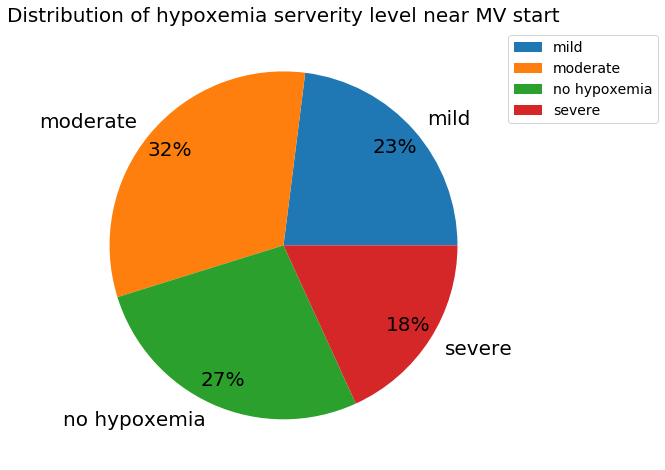

In [167]:
# plot distribution of hypo category at first and last time points:
# Near IV start:
pl = first_last_label_gap.hyp_cat_first.value_counts().sort_index().plot.pie(figsize=(8, 8), autopct='%1.0f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_title('Distribution of hypoxemia serverity level near MV start', fontdict={'fontsize': 20})
pl.set_ylabel('')

In [161]:
# Near IV start+24h:
first_last_label_gap.hyp_cat_last.value_counts().sort_index()

mild            2422
moderate        2737
no hypoxemia    1962
severe           786
Name: hyp_cat_last, dtype: int64

Text(0, 0.5, '')

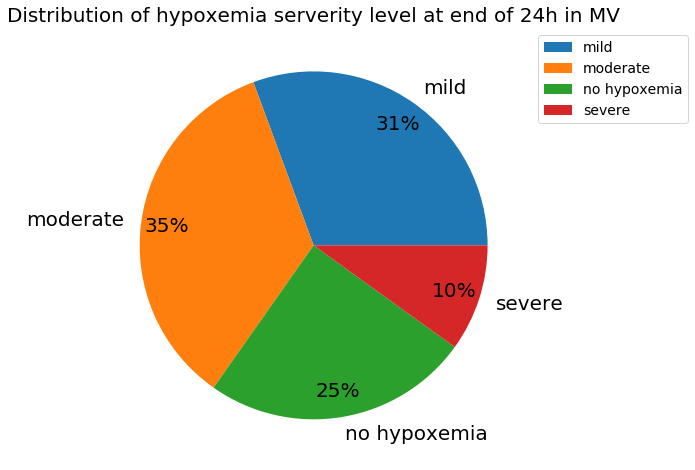

In [168]:
pl = first_last_label_gap.hyp_cat_last.value_counts().sort_index().plot.pie(figsize=(8, 8), autopct='%1.0f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_title('Distribution of hypoxemia serverity level at end of 24h in MV', fontdict={'fontsize': 20})
pl.set_ylabel('')

In [158]:
# outcome distribution:
first_last_label_gap.is_worse.value_counts()

0    6075
1    1832
Name: is_worse, dtype: int64

Text(0, 0.5, '')

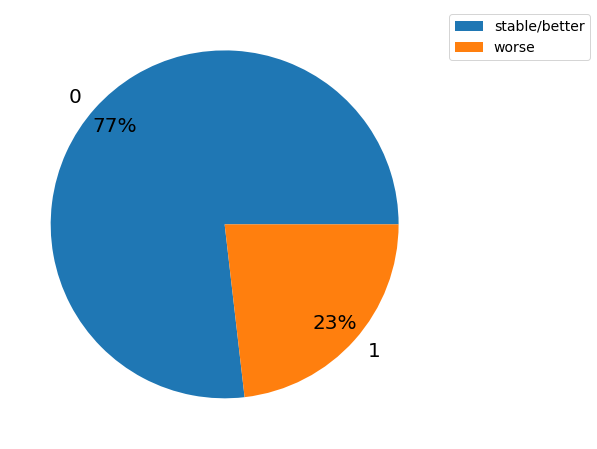

In [110]:
# plot the hypoxemia level distribution
pl = first_last_label_gap.is_worse.value_counts().plot.pie(figsize=(8, 8), autopct='%1.0f%%',\
                                                     pctdistance=0.85, labeldistance=1.1, textprops={'fontsize': 20})
pl.legend(['stable/better', 'worse'], prop={'size':14}, bbox_to_anchor=(1.0, 1.0))
pl.set_ylabel('')

In [0]:
first_last_label_gap.to_csv('hypoxemia_outcome_with_12hr_gap.csv')
#files.download('hypoxemia_outcome_with_12hr_gap.csv')

In [91]:
first_last_label_gap[first_last_label_gap.chartoffset_hrs_last<0]

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last,time_gap
4035,999150,-82.366667,178.57,moderate,-66.533333,372.00,no hypoxemia,15.83
4211,1019607,-20.466667,170.00,moderate,-8.466667,187.50,moderate,12.00
10367,2321327,-21.966667,103.00,moderate,-5.983333,84.00,severe,15.98
10452,2343485,-16.033333,405.00,no hypoxemia,-1.016667,373.33,no hypoxemia,15.02
10907,2479203,-48.816667,85.50,severe,-32.566667,127.14,moderate,16.25
25781,3208898,-146.883333,38.00,severe,-124.033333,182.00,moderate,22.85
25786,3209249,-201.566667,280.00,mild,-187.766667,312.50,no hypoxemia,13.80
25978,3222548,-277.533333,285.00,mild,-254.883333,350.00,no hypoxemia,22.65
26001,3224322,-26.933333,151.00,moderate,-10.800000,45.71,severe,16.13
26074,3230298,-46.416667,132.00,moderate,-25.283333,162.50,moderate,21.13


In [0]:

no_PF_ids = set(first_icuid_dict.keys())-set(first_last_label_gap.patientunitstayid) # may have/have not PF, but gap is not sufficient/IV duration is very short 

In [111]:
len(no_PF_ids)

30916

In [112]:
no_PF_ids

{262151,
 1835016,
 1572872,
 1572877,
 2228239,
 655378,
 3145760,
 3145763,
 1572900,
 2883628,
 1572909,
 1703983,
 655413,
 393272,
 3014713,
 3145787,
 1966141,
 2752573,
 2883649,
 1572929,
 3014725,
 2097227,
 1966157,
 1048654,
 2883665,
 2752594,
 1048660,
 1048668,
 2490468,
 2883685,
 1572964,
 2883688,
 3014771,
 1572979,
 3014778,
 393346,
 2097283,
 2752650,
 2228362,
 3145868,
 1573003,
 1835155,
 1179797,
 2621594,
 1573020,
 1573027,
 1835172,
 1573028,
 3014838,
 524473,
 1573050,
 1704123,
 393404,
 1704126,
 1048767,
 2621632,
 1441993,
 1704142,
 2752721,
 3145940,
 2359516,
 1966303,
 2883809,
 786657,
 3145958,
 2490599,
 1704168,
 524522,
 786673,
 2621691,
 3145983,
 1442048,
 655619,
 2752772,
 2883850,
 2228492,
 1966350,
 1179919,
 2883856,
 1048851,
 3014941,
 393503,
 2621728,
 524577,
 2883874,
 786719,
 2097448,
 1835313,
 1048882,
 393526,
 2490682,
 655675,
 2490685,
 2621758,
 1966402,
 1573196,
 2359629,
 1048911,
 2883919,
 1835346,
 3146068,
 13110

In [86]:
# Example:
df_outcome_NL[df_outcome_NL.patientunitstayid==1445694]

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
188497,1445694,1,0.50,83.0,166.00
188498,1445694,287,0.41,109.0,265.85
188499,1445694,425,0.41,95.0,231.71


In [92]:
first_icuid_dict[1445694]

{'ICU Admit': [0], 'ICU Discharge': [49.42], 'IV': [(0.38, 8.6)]}

In [117]:
# Example:
first_icuid_dict[2887601]

{'ICU Admit': [0], 'ICU Discharge': [93.03], 'IV': [(4.95, nan)]}

In [125]:
min(27, first_icuid_dict[2887601]['IV'][0][1])

27

In [115]:
df_outcome_NL[df_outcome_NL.patientunitstayid==2887601]


,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
322028,2887601,-233,1.00,570.0,570.00
322029,2887601,50,0.40,125.0,312.50
322030,2887601,132,0.40,147.0,367.50
322031,2887601,457,0.30,65.0,216.67
322032,2887601,1950,0.30,60.0,200.00
322033,2887601,3396,0.35,72.0,205.71


In [128]:
first_pf[first_pf.patientunitstayid==2887601]

,patientunitstayid,chartoffset_hrs_first,pf_ratio_first,hyp_cat_first
0,2887601,7.616667,216.67,mild


In [129]:
first24hr_pf[first24hr_pf.patientunitstayid==2887601]

,patientunitstayid,chartoffset_hrs_last,pf_ratio_last,hyp_cat_last
0,2887601,7.616667,216.67,mild


In [152]:
# Are their any patients with no PF values from our final IV dict? 7262 (without considering time in MV)
# How many patients with no PF values from our IV dict with min 12h MV time? 5877
cnt = 0
for id in first_icuid_dict.keys():
  total_IV_time = np.array([i[1]- i[0] for i in first_icuid_dict[id]['IV']]).sum()
  if (total_IV_time>=12.0) | (np.isnan(total_IV_time) == True):
    df_id = df_outcome_NL[df_outcome_NL.patientunitstayid==id]
    if df_id.shape[0] == 0:
      print(id)
      print(first_icuid_dict[id])
      cnt += 1
print(cnt)


142388
{'IV': [(1.23, 99.33)], 'ICU Admit': [0], 'ICU Discharge': [140.12]}
145617
{'IV': [(0.27, 17.9)], 'ICU Admit': [0], 'ICU Discharge': [44.87]}
154955
{'IV': [(63.93, 83.43)], 'ICU Admit': [0], 'ICU Discharge': [99.35]}
165504
{'IV': [(0.08, nan)], 'ICU Admit': [0], 'ICU Discharge': [220.22]}
167670
{'IV': [(0.47, 17.43)], 'ICU Admit': [0], 'ICU Discharge': [34.7]}
168728
{'IV': [(0.27, 83.63)], 'ICU Admit': [0], 'ICU Discharge': [139.28]}
169355
{'IV': [(6.13, 24.7)], 'ICU Admit': [0], 'ICU Discharge': [30.48]}
175574
{'IV': [(25.97, 44.17)], 'ICU Admit': [0], 'ICU Discharge': [74.8]}
177707
{'IV': [(0.53, 20.62)], 'ICU Admit': [0], 'ICU Discharge': [72.1]}
186937
{'IV': [(0.12, 147.13)], 'ICU Admit': [0], 'ICU Discharge': [184.77]}
190338
{'IV': [(3.6, 50.82)], 'ICU Admit': [0], 'ICU Discharge': [113.58]}
193099
{'IV': [(2.57, 37.33)], 'ICU Admit': [0], 'ICU Discharge': [44.38]}
195551
{'IV': [(1.58, 131.08)], 'ICU Admit': [0], 'ICU Discharge': [177.65]}
195649
{'IV': [(0.18, 4

In [134]:
df_outcome_NL[df_outcome_NL.patientunitstayid==1966459] 

,patientunitstayid,chartoffset,fio2,pao2,pf_ratio
